In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Read the csv file into a DataFrame
df = pd.read_csv('Uncencored Headcount Ratio of all districts of odhisa.csv')
df_modified = df.drop( columns= 'District')
data = df_modified.values
data = data / 100
# Subtract 0.01 and add 0.01 to each entry
data_intervals = np.empty(data.shape + (2,))
data_intervals[:, :, 0] = data - 0.01
data_intervals[:, :, 1] = data + 0.01
targets = data[:, 0:1]
inputs = data_intervals[:, 1:, :]
print(inputs.shape)
print(targets.shape)

(30, 12, 2)
(30, 1)


In [3]:
# Convert NumPy arrays to PyTorch tensors
input_tensor = torch.tensor(inputs, dtype=torch.float32)
output_tensor = torch.tensor(targets, dtype=torch.float32)

In [4]:
def multiply_interval_matrices(A, B):
    """
    Multiply two interval matrices using interval operations.

    Args:
    A: torch tensor, shape (m, n, 2), interval matrix A
    B: torch tensor, shape (n, p, 2), interval matrix B

    Returns:
    C: torch tensor, shape (m, p, 2), interval matrix resulting from A*B
    """
    # Extract the interval bounds
    A_low, A_high = A[..., 0], A[..., 1]
    B_low, B_high = B[..., 0], B[..., 1]

    # Initialize the result tensor
    m, n, _ = A.shape
    _, p, _ = B.shape
    C = torch.zeros((m, p, 2))

    # Compute all possible products for intervals
    products = torch.stack([
        A_low.unsqueeze(2) * B_low.unsqueeze(0),  # A[i, k, 0] * B[k, j, 0]
        A_low.unsqueeze(2) * B_high.unsqueeze(0), # A[i, k, 0] * B[k, j, 1]
        A_high.unsqueeze(2) * B_low.unsqueeze(0), # A[i, k, 1] * B[k, j, 0]
        A_high.unsqueeze(2) * B_high.unsqueeze(0) # A[i, k, 1] * B[k, j, 1]
    ], dim=-1)

    # Compute min and max across the last dimension
    min_product, _ = torch.min(products, dim=-1)
    max_product, _ = torch.max(products, dim=-1)

    # Sum across the middle dimension (n) for the final result
    C[..., 0] = torch.sum(min_product, dim=1)
    C[..., 1] = torch.sum(max_product, dim=1)

    return C


In [5]:
def interval_addition(A, B):
    """
    Add two interval matrices.

    Args:
    A: torch tensor, shape (..., 2), interval matrix A
    B: torch tensor, shape (..., 2), interval matrix B

    Returns:
    C: torch tensor, shape (..., 2), interval matrix resulting from A + B
    """
    C_lower = A[..., 0] + B[..., 0]
    C_upper = A[..., 1] + B[..., 1]
    return torch.stack((C_lower, C_upper), dim=-1)


In [6]:
def relu_interval(x):
    lower, upper = x[..., 0], x[..., 1]
    return torch.stack((nn.SiLU()(lower),nn.SiLU()(upper)), dim=-1)

In [7]:
# Splitting data into training and testing sets
train_input_tensor, test_input_tensor, train_output_tensor, test_output_tensor = train_test_split(
    input_tensor, output_tensor, test_size=0.2, random_state=1
)
print(train_input_tensor.shape, test_input_tensor.shape, train_output_tensor.shape, test_output_tensor.shape)

torch.Size([24, 12, 2]) torch.Size([6, 12, 2]) torch.Size([24, 1]) torch.Size([6, 1])


In [8]:
# Define batch size
batch_size = 8

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(train_input_tensor, train_output_tensor)
test_dataset = TensorDataset(test_input_tensor, test_output_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

torch.manual_seed(2)

In [9]:
class CustomLinear(nn.Module):
    def __init__(self, input_size, output_size):
        super(CustomLinear, self).__init__()    
        self.weight = nn.Parameter(torch.Tensor(input_size, output_size, 2))
        self.bias = nn.Parameter(torch.Tensor(1, output_size, 2))
        self.reset_parameters()
        
    def reset_parameters(self):
        # Using Xavier initialization for weights
        nn.init.kaiming_uniform_(self.weight[..., 0])
        nn.init.zeros_(self.bias[..., 0])
        nn.init.kaiming_uniform_(self.weight[..., 1])
        nn.init.zeros_(self.bias[..., 1])
        # Ensure the interval property: upper bound >= lower bound
        #self.weight.data[..., 1] = self.weight.data[..., 0] + torch.abs(self.weight.data[..., 1])
        # Ensure the interval property for biases
        #self.bias.data[..., 1] = self.bias.data[..., 0] + torch.abs(self.bias.data[..., 1])
        # Ensure that the upper bound is greater than or equal to the lower bound
        # Ensure the interval property: upper bound >= lower bound
        self.weight.data[..., 0], self.weight.data[..., 1] = torch.min(self.weight.data[..., 1], self.weight.data[..., 0]), torch.max(self.weight.data[..., 1], self.weight.data[..., 0])
        self.bias.data[..., 0], self.bias.data[..., 1] = torch.min(self.bias.data[..., 1], self.bias.data[..., 0]), torch.max(self.bias.data[..., 1], self.bias.data[..., 0])

        
    def forward(self, x):
        weighted_input = multiply_interval_matrices(x, self.weight)
        output = interval_addition(weighted_input, self.bias)
        
        # Ensure interval property is maintained
        lower, upper = torch.min(output[..., 0], output[..., 1]), torch.max(output[..., 0], output[..., 1])
        
        return torch.stack((lower, upper), dim=-1)
    def project(self):
        # Ensure that the upper bound is greater than or equal to the lower bound
        # Ensure the interval property: upper bound >= lower bound
        self.weight.data[..., 0], self.weight.data[..., 1] = torch.min(self.weight.data[..., 1], self.weight.data[..., 0]), torch.max(self.weight.data[..., 1], self.weight.data[..., 0])
        self.bias.data[..., 0], self.bias.data[..., 1] = torch.min(self.bias.data[..., 1], self.bias.data[..., 0]), torch.max(self.bias.data[..., 1], self.bias.data[..., 0])

        
# Define the neural network model with custom linear layers
class CustomNeuralNetwork(nn.Module):
    def __init__(self):
        super(CustomNeuralNetwork, self).__init__()
        self.layer1 = CustomLinear(input_tensor.shape[1], 16)
        self.activation = relu_interval
        self.layer2 = CustomLinear(16, 16)
        self.activation = relu_interval
        #self.layer3 = CustomLinear(20, 20)
        #self.activation = relu_interval
        self.layer4 = CustomLinear(16, output_tensor.shape[1])

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.layer2(x)
        x = self.activation(x)
        #x = self.layer3(x)
        #x = self.activation(x)
        x = self.layer4(x)
        return x
    
class IntervalMSELoss(nn.Module):
    def __init__(self, beta):
        super(IntervalMSELoss, self).__init__()
        self.beta = beta

    def distance(self, a, x_lower, x_upper):
        return  (1/4) * (2 * a - x_upper - x_lower) ** 2

    def forward(self, y_true, y_pred):
        y_pred_lower = y_pred[..., 0]
        y_pred_upper = y_pred[..., 1]
        y_true = y_true#.squeeze(1)
        
        d =   self.distance(y_true, y_pred_lower, y_pred_upper)
        interval_difference =  y_pred_upper - y_pred_lower

        # Create a tensor of the same size as X, filled with the value 'a'
        #zero_tensor = torch.full_like(interval_difference, 0)
        width_term = self.beta * interval_difference ** 2
        #width_term = self.beta * torch.max(zero_tensor, interval_difference) ** 2
        loss = torch.mean(d + width_term) #
        return loss
    
    

# Initialize the model, loss function, and optimizer
model = CustomNeuralNetwork()
beta = 0.2
criterion = IntervalMSELoss(beta=beta)
optimizer = optim.AdamW(model.parameters(), lr=0.003, weight_decay=1e-1)
scheduler = StepLR(optimizer, step_size=1000, gamma=0.5)  #Reduce LR by a factor of 0.5 every 1000 epochs


# Training the model with early stopping, validation loss tracking, and gradient clipping
patience = 500
best_loss = float('inf')
trigger_times = 0
train_losses = []
val_losses = []

# Implement gradient clipping in the training loop
max_grad_norm = 1.0

# Training the model with early stopping and validation loss tracking
epochs = 10000

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0
    for batch_inputs, batch_outputs in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(batch_outputs, outputs)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        
        optimizer.step()
        epoch_train_loss += loss.item()
        
    scheduler.step()  # Step the learning rate scheduler
    epoch_train_loss /= len(train_loader)

    # Calculate validation loss
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch_inputs, batch_outputs in test_loader:
            val_outputs = model(batch_inputs)
            val_loss = criterion(batch_outputs, val_outputs)
            epoch_val_loss += val_loss.item()

    epoch_val_loss /= len(test_loader)

    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_train_loss:.6f}, Val Loss: {epoch_val_loss:.6f}')
    
    if epoch_val_loss < best_loss:
        best_loss = epoch_val_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break
       
    # Project weights and biases to ensure interval constraints
    model.layer1.project()
    model.layer2.project()
    #model.layer3.project()
    model.layer4.project()

Epoch 100/10000, Loss: 0.042563, Val Loss: 0.062043
Epoch 200/10000, Loss: 0.011566, Val Loss: 0.019407
Epoch 300/10000, Loss: 0.006701, Val Loss: 0.011173
Epoch 400/10000, Loss: 0.005008, Val Loss: 0.007704
Epoch 500/10000, Loss: 0.003678, Val Loss: 0.005827
Epoch 600/10000, Loss: 0.003183, Val Loss: 0.004904
Epoch 700/10000, Loss: 0.002359, Val Loss: 0.003757
Epoch 800/10000, Loss: 0.001804, Val Loss: 0.003056
Epoch 900/10000, Loss: 0.001731, Val Loss: 0.002813
Epoch 1000/10000, Loss: 0.001406, Val Loss: 0.002297
Epoch 1100/10000, Loss: 0.000836, Val Loss: 0.001704
Epoch 1200/10000, Loss: 0.000834, Val Loss: 0.001634
Epoch 1300/10000, Loss: 0.000830, Val Loss: 0.001556
Epoch 1400/10000, Loss: 0.000803, Val Loss: 0.001478
Epoch 1500/10000, Loss: 0.000767, Val Loss: 0.001354
Epoch 1600/10000, Loss: 0.000779, Val Loss: 0.001382
Epoch 1700/10000, Loss: 0.000730, Val Loss: 0.001287
Epoch 1800/10000, Loss: 0.000723, Val Loss: 0.001227
Epoch 1900/10000, Loss: 0.000677, Val Loss: 0.001127
Ep

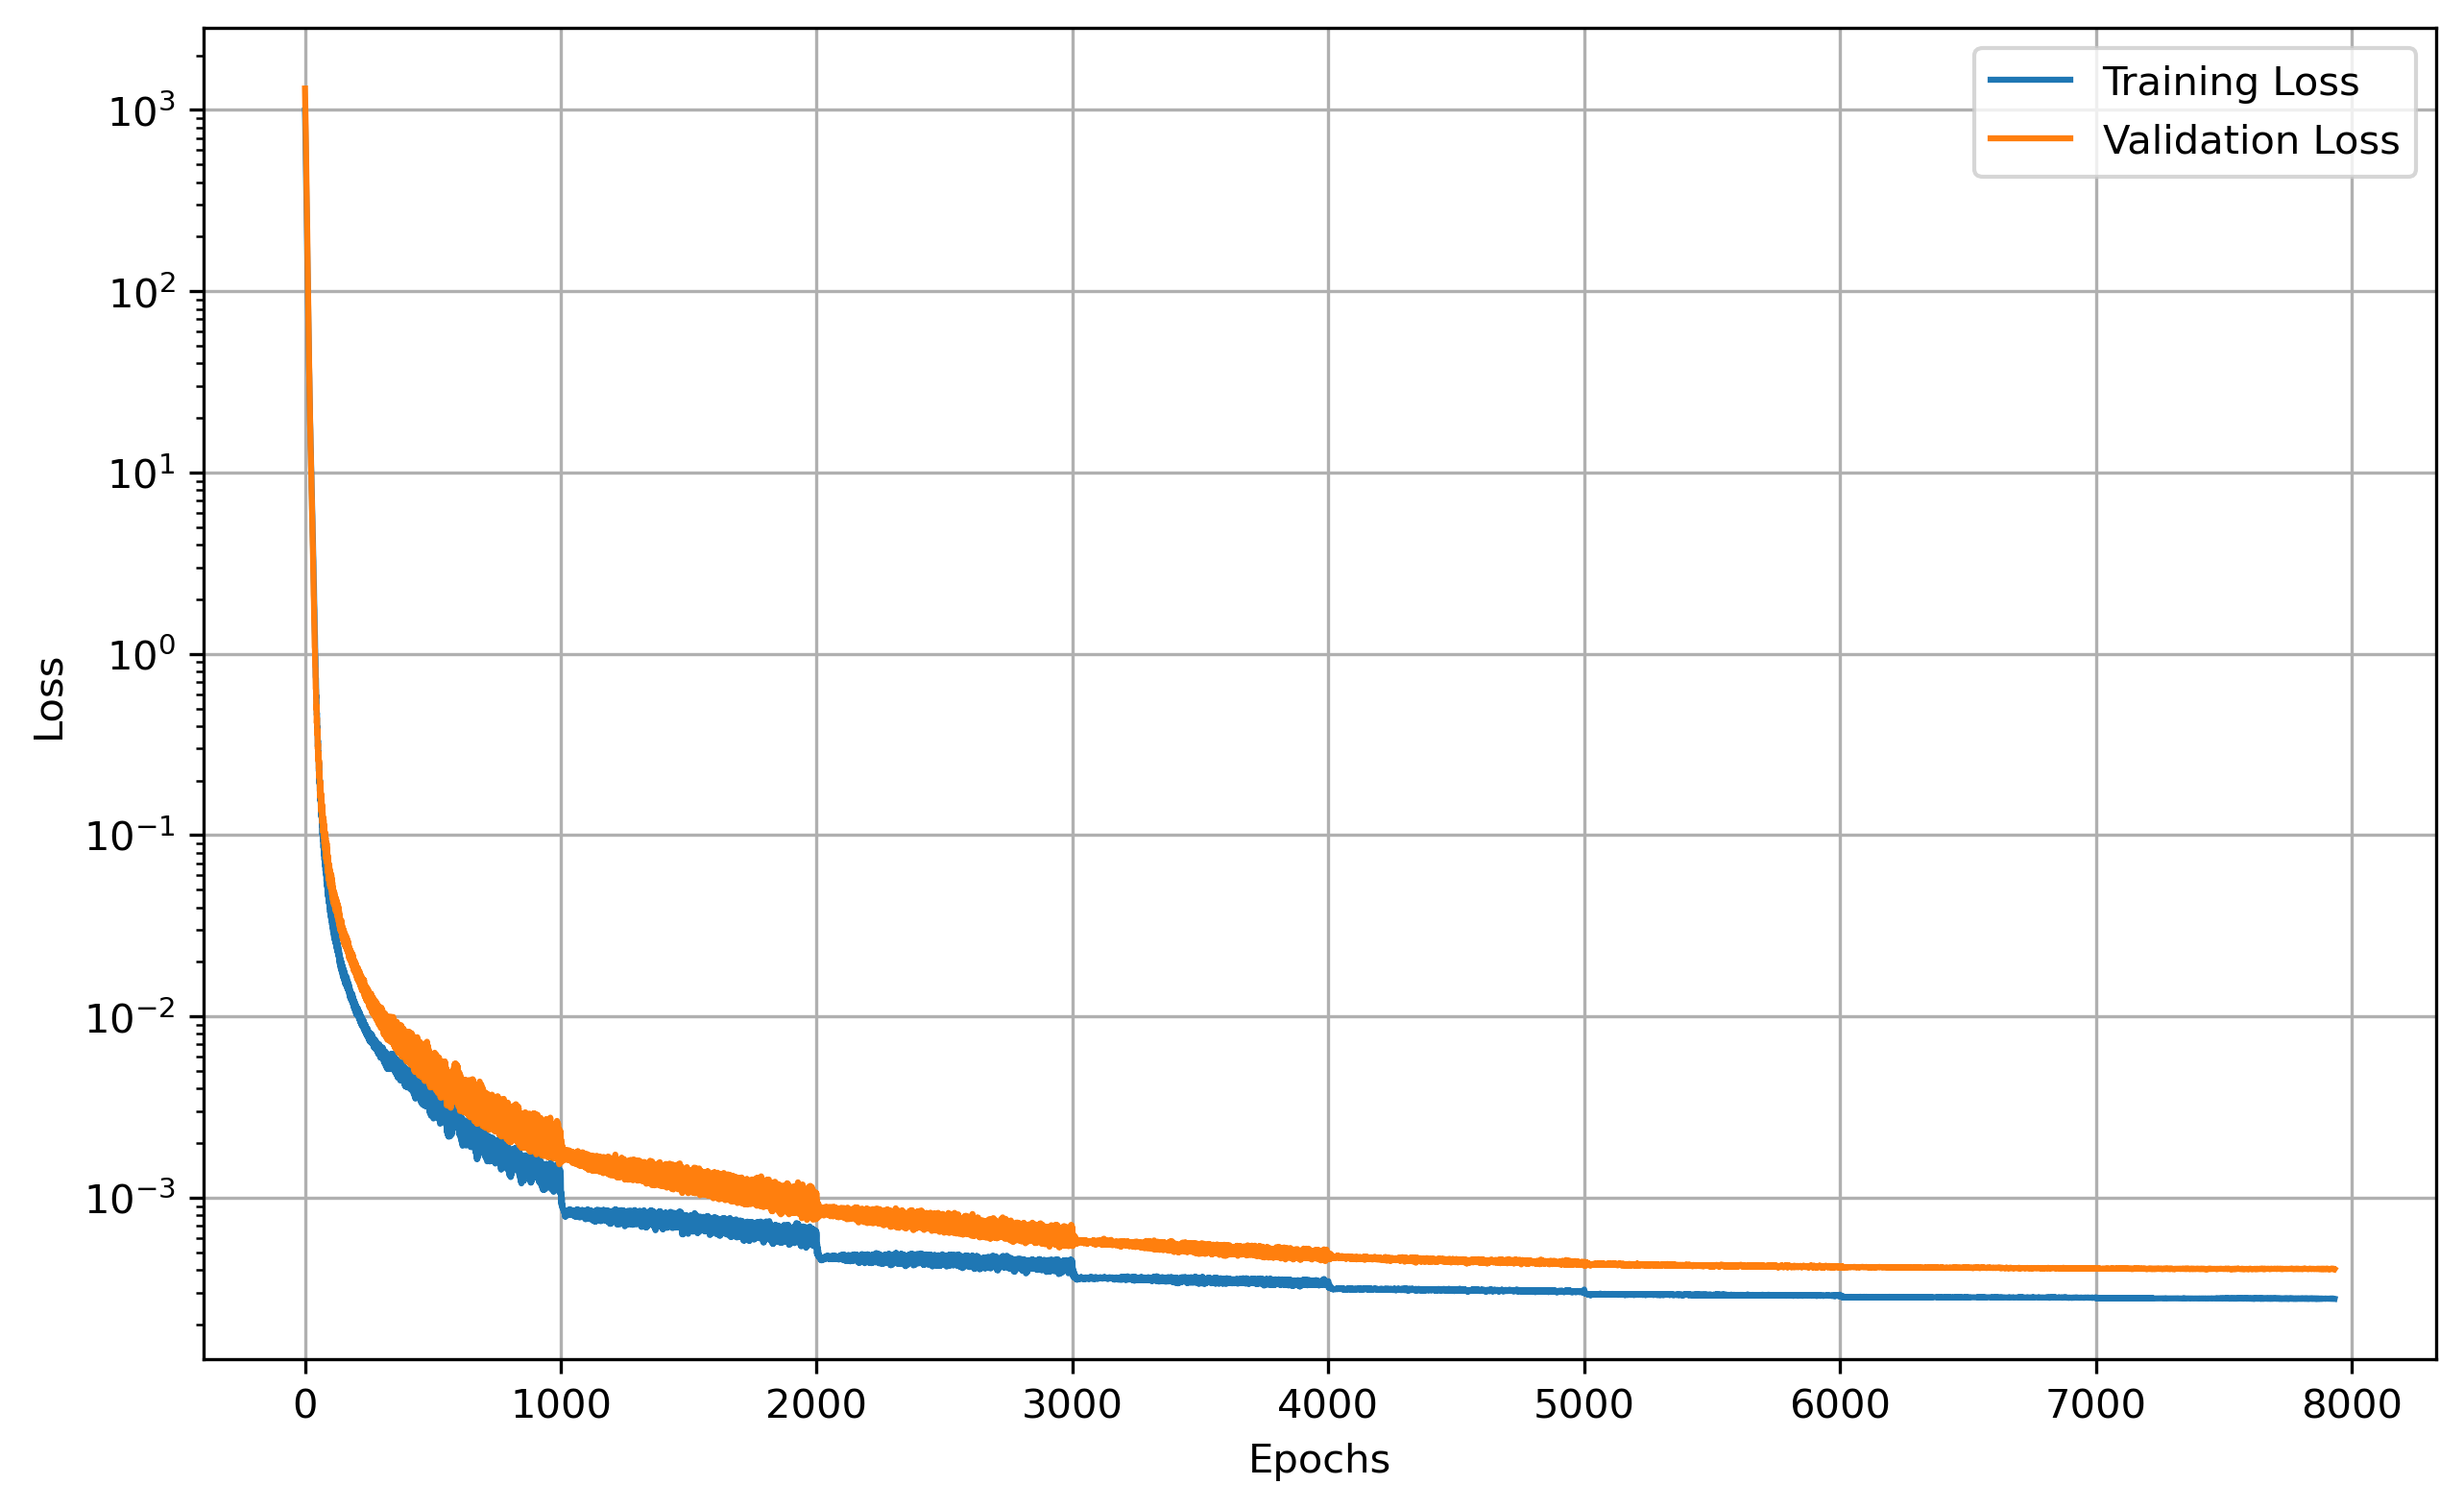

In [10]:
# Plotting training and validation loss curves
plt.figure(figsize=(10, 6), dpi = 300)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
#plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
#plt.show()
plt.savefig('Training and Validation Loss Curve.pdf')

In [11]:
# Evaluate the trained model
with torch.no_grad():
    outputs = model(input_tensor)
    accuracy = (1 - torch.abs((outputs[..., 0] + outputs[..., 1])/2 - output_tensor).mean()).float()
    print(f'Accuracy: {accuracy.item():.5f}')

Accuracy: 0.99044


In [12]:
outputs = model(input_tensor)
print(outputs)

tensor([[[0.2160, 0.2388]],

        [[0.2925, 0.3179]],

        [[0.2412, 0.2650]],

        [[0.2447, 0.2680]],

        [[0.3066, 0.3296]],

        [[0.2728, 0.2967]],

        [[0.1339, 0.1607]],

        [[0.3639, 0.3876]],

        [[0.2817, 0.3038]],

        [[0.3796, 0.4055]],

        [[0.1972, 0.2237]],

        [[0.1206, 0.1458]],

        [[0.1962, 0.2210]],

        [[0.1749, 0.2052]],

        [[0.4570, 0.4854]],

        [[0.4405, 0.4658]],

        [[0.2011, 0.2238]],

        [[0.4152, 0.4395]],

        [[0.1365, 0.1677]],

        [[0.5028, 0.5323]],

        [[0.5349, 0.5744]],

        [[0.4248, 0.4538]],

        [[0.5530, 0.5958]],

        [[0.2062, 0.2292]],

        [[0.3476, 0.3715]],

        [[0.0965, 0.1263]],

        [[0.4682, 0.4926]],

        [[0.2370, 0.2646]],

        [[0.2520, 0.2743]],

        [[0.2424, 0.2689]]], grad_fn=<StackBackward0>)


In [13]:
print(output_tensor)

tensor([[0.2457],
        [0.2749],
        [0.2442],
        [0.2490],
        [0.3303],
        [0.2843],
        [0.1497],
        [0.3710],
        [0.3008],
        [0.3876],
        [0.2188],
        [0.1183],
        [0.2075],
        [0.1862],
        [0.4728],
        [0.4475],
        [0.2167],
        [0.4178],
        [0.1549],
        [0.5114],
        [0.5871],
        [0.4490],
        [0.5932],
        [0.2049],
        [0.3798],
        [0.1164],
        [0.4814],
        [0.2453],
        [0.2805],
        [0.2475]])


In [14]:
# After training
# Print weights and biases
#print("Weights of layer 1:")
#print(model.layer1.weight)
#print("Biases of layer 1:")
#print(model.layer1.bias)

#print("Weights of layer 2:")
#print(model.layer2.weight)
#print("Biases of layer 2:")
#print(model.layer2.bias)

In [15]:
# Calculate the total number of trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_params)

Total number of trainable parameters: 994
